## 4. Predicción de fugas de clientes en una compañía telefónica (7 puntos)

Una compañía telefónica está interesada en que desarrollemos un modelo que prediga los **100 clientes actuales** (dataset de explotaación) que tienen más probabilidad de abandonar la compañía. Para ello nos proporcionan una base de datos **fuga_clientes_empresa_telefonica_construccion.csv** con casos etiquetados, que usaremos para construir nuestro modelo de predicción.

Los campos de esta base de datos son:

* **Customer ID**

* **network_age**: antigüedad del cliente en días

* **Customer tenure in months:** antigüedad del cliente en meses

* **Total Spend in Months 1 and 2:** gasto total del cliente en los meses de referencia 1 y 2

* **Total SMS Spend:** gasto total en SMS

* **Total Data Spend:** gasto total en datos/internet

* **Total Data Consumption:** consumo total de datos (en KB) durante el período de estudio

* **Total Unique Calls:** número total de llamadas únicas

* **Total Onnet spend:** gasto total en llamadas a otros usuarios de la misma red de telefonía

* **Total Offnet spend:** gasto total en llamadas a otros usuarios de redes de telefonía diferentes

* **Total Call centre complaint calls:** número de llamadas de queja al call center

* **Network type subscription in Month 1:** suscripción de tipo de red en el mes 1. Esto indica la suscripción de red preferida de un cliente, lo que puede indicar su tipo de dispositivo: servicio 2G o 3G

* **Network type subscription in Month 2:** igual que el anterior pero en el mes posterior

* **Churn Status**: el valor es 1 si el cliente abandona la compañía telefónica, 0 si permanece en ella

* **Most Loved Competitor network in Month 1:** qué otro proveedor de la competencia prefiere el cliente en el mes 1. En realidad es un conjunto de columnas, cada una enfocada en un proveedor particular

* **Most Loved Competitor network in Month 2:** qué otro proveedor de la competencia prefiere el cliente en el mes 2. En realidad es un conjunto de columnas, cada una enfocada en un proveedor particular

La variable a predecir es **Churn Status**: el valor es 1 si el cliente **abandona** la compañía, 0 si no la abandona.

La compañía también nos proporciona otra base de datos, **fuga_clientes_empresa_telefonica_explotacion.csv**, con información sobre clientes de los que no se sabe ahora mismo si van a permanecer o no en la compañía. Por tanto en esta segunda base de datos todos los valores de la columna **Churn Status** son missing values (NaN).

La compañía nos pide que proporcionemos los IDs de los 100 clientes de la base de datos de explotación que con mayor probabilidad vayan a abandonar la compañía. Para ello proporcionaremos como entregable a la compañía un archivo csv con una sola columna, **Customer ID**, y 100 filas que contengan los IDs de los clientes seleccionados.

El fichero **ejemplo_fichero_predicciones.csv** contiene un ejemplo con el formato solicitado para este archivo.

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
datos_construccion = pd.read_csv("./fuga_clientes_empresa_telefonica_construccion.csv")
datos_explotacion  = pd.read_csv("./fuga_clientes_empresa_telefonica_explotacion.csv")

In [80]:
datos_construccion.columns

Index(['Customer ID', 'network_age', 'Customer tenure in month',
       'Total Spend in Months 1 and 2', 'Total SMS Spend', 'Total Data Spend',
       'Total Data Consumption', 'Total Unique Calls', 'Total Onnet spend',
       'Total Offnet spend', 'Total Call centre complaint calls',
       'Churn Status', 'Most Loved Competitor network in Month 1_0',
       'Most Loved Competitor network in Month 1_Mango',
       'Most Loved Competitor network in Month 1_PQza',
       'Most Loved Competitor network in Month 1_ToCall',
       'Most Loved Competitor network in Month 1_Uxaa',
       'Most Loved Competitor network in Month 1_Weematel',
       'Most Loved Competitor network in Month 1_Zintel',
       'Most Loved Competitor network in Month 2_Mango',
       'Most Loved Competitor network in Month 2_PQza',
       'Most Loved Competitor network in Month 2_ToCall',
       'Most Loved Competitor network in Month 2_Uxaa',
       'Most Loved Competitor network in Month 2_Weematel',
       'Most 

In [81]:
datos_explotacion.columns

Index(['Customer ID', 'network_age', 'Customer tenure in month',
       'Total Spend in Months 1 and 2', 'Total SMS Spend', 'Total Data Spend',
       'Total Data Consumption', 'Total Unique Calls', 'Total Onnet spend',
       'Total Offnet spend', 'Total Call centre complaint calls',
       'Churn Status', 'Most Loved Competitor network in Month 1_0',
       'Most Loved Competitor network in Month 1_Mango',
       'Most Loved Competitor network in Month 1_PQza',
       'Most Loved Competitor network in Month 1_ToCall',
       'Most Loved Competitor network in Month 1_Uxaa',
       'Most Loved Competitor network in Month 1_Weematel',
       'Most Loved Competitor network in Month 1_Zintel',
       'Most Loved Competitor network in Month 2_Mango',
       'Most Loved Competitor network in Month 2_PQza',
       'Most Loved Competitor network in Month 2_ToCall',
       'Most Loved Competitor network in Month 2_Uxaa',
       'Most Loved Competitor network in Month 2_Weematel',
       'Most 

In [82]:
# chequeo de que las columnas son exactamente las mismas en los dos ficheros:

sum(datos_construccion.columns != datos_explotacion.columns)

0

In [83]:
# la columna a predecir es "Churn Status"
# si es 1, el cliente se va de la compañía
# si es 0, el cliente se queda

# Esta columna se sabe en el dataset de construcción (ejemplos de clientes pasados):
datos_construccion["Churn Status"].values[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [84]:
# Sin embargo no se sabe en el dataset de explotación (clientes actuales):
datos_explotacion["Churn Status"].values[:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

The first step is to divide the data of the dataset into X,y: the data itself and the class. It is important to remove the Customer ID as it is not relevant for the training of the classifiers. 
After reviewing the data provided, we found some non-sensical values that should be removed in order to improve the quality and clarity of the data. These values were: 
- Negative values in the 'network_age' attribute. If the attribute describes an age, it should be impossible to have negative values as instances.
- The attribute 'customer tenure in months'. We already have an attribute describing the same information in days, it is irrelevant to have it in months. 

Apart from the division of the data, we also printed the amount of instances with each class, in order to determine if the dataset was balanced. The values for the count were (571, 537) so, it was safe to say that the dataset was mostly balanced.

In [85]:
print(type(datos_construccion))
# Remove negative values in attribute network_age
print('Instances before deletion: ', len(datos_construccion.index))
datos_construccion = datos_construccion[datos_construccion['network_age'] >= 0]
print('Instances after deletion: ', len(datos_construccion.index))

# Remove 'customer tenure in months'
datos_construccion = datos_construccion.drop(columns=['Customer tenure in month',])

# Obtain attribute names
attribute_names = list(datos_construccion.columns)
attribute_names.remove('Churn Status')
attribute_names.remove('Customer ID')
print('Number of attributes: ', len(attribute_names))

X = datos_construccion[attribute_names].values
y = datos_construccion['Churn Status'].values

print('Data: ', X[0])
print('Class: ', y[0])

print('# Churn Status = 0 : ', (y == 0).sum())
print('# Churn Status = 1 : ', (y == 1).sum())

X_predict = datos_explotacion[attribute_names].values


<class 'pandas.core.frame.DataFrame'>
Instances before deletion:  1110
Instances after deletion:  1108
Number of attributes:  22
Data:  [1.2300e+02 7.6714e+01 0.0000e+00 1.2500e+00 1.4951e+00 1.4000e+01
 5.6400e+02 6.4080e+03 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
Class:  0
# Churn Status = 0 :  571
# Churn Status = 1 :  537


We also decided to plot the density distributions of the attributes in order to gain a better understanding of the dataset. In the end it was not very telling because most of the attributes had similar distrubtions for both classes, with the exception of the 'Most loved competitor' attributes.

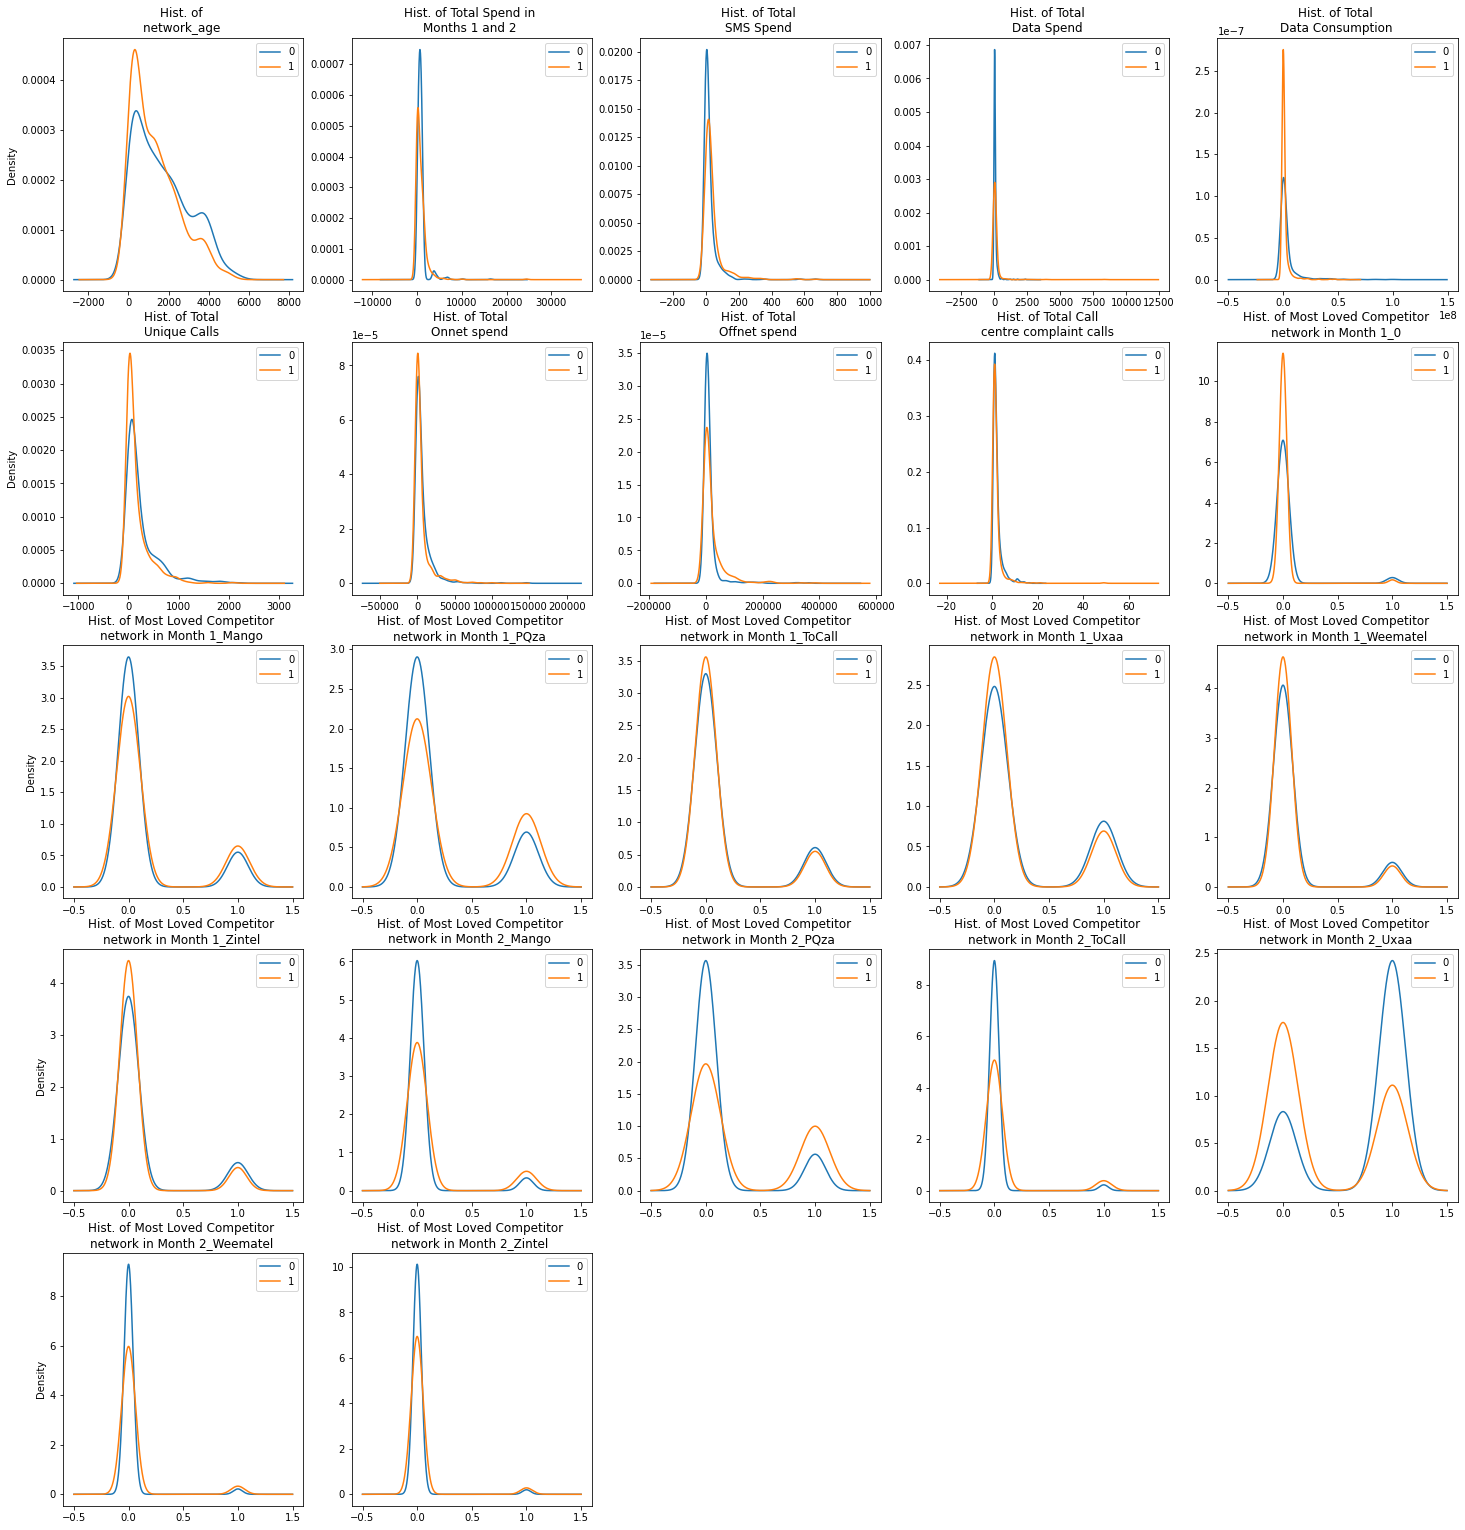

In [69]:
plt.figure(figsize=(25,27))
for i,n in enumerate(attribute_names):
    plt.subplot(5,5,i+1)
    aux = 'Density' if i%5 == 0 else ''
    name_1 = n.split(' ')[:int(len(n.split(' '))/2)]
    name_2 = n.split(' ')[int(len(n.split(' '))/2):]
    name = ''
    for x in name_1: name += x + ' ' 
    name += '\n'
    for x in name_2: name += x + ' '
    datos_construccion.groupby('Churn Status')[n].plot(kind='kde', title='Hist. of '+name)
    plt.ylabel(aux);
    plt.legend()

The next step would be to test different classifiers and evaluate how good the classification is. We will test with three types of classifiers: KNNeighbors, DecicisionTree and Neural Network. We will also test different values for the hyperparameters to search for the best predictions. In order to decide what the best configuration is, the best solution is to use Cross Validation. We will use 5-fold cross validation.

In [86]:
print('Cross Validation for Decision Tree...')
best_depth = None
best_depth_value = 0
for depth in range(2,15):
    scores = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=depth),
                                                    X, y, cv=5)
    print('Depth {}: {:.2f} +/- {:.2f}'.format(depth, scores.mean(), scores.std()))
    if scores.mean() > best_depth_value:
        best_depth_value = scores.mean()
        best_depth = depth

print('Cross Validation for Neural Network...')
"""layer_structures = {0: [[]], 'tuples': []}

for i in range(1,6):
    layer_structures[i] = []
    for ii in range(1,90,2):
        for l in layer_structures[i-1]:
                layer_structures[i].append(l + [ii])
                layer_structures['tuples'].append(tuple(l+[ii]))"""
layer_structures = {'tuples': []}
for i in range(1, 90, 3):
    neuron_layer = []
    for ii in range(6):
            neuron_layer.append(i)
            layer_structures['tuples'].append(tuple(neuron_layer))

best_layer = None  
best_layer_value = 0  
for layer in layer_structures['tuples']: 
            scores = cross_val_score(MLPClassifier(hidden_layer_sizes=layer, max_iter=1000, alpha=0), X, y, cv=5)
            print('Layer structure {}: {:.2f} +/- {:.2f}'.format(layer, scores.mean(), scores.std()))
            if scores.mean() > best_layer_value:
                best_layer_value = scores.mean()
                best_layer = layer

best_neighbor = None
best_neighbor_value = 0
for neighbors in range(1, 20, 2):
    scores = cross_val_score(KNeighborsClassifier(n_neighbors=neighbors), X, y, cv=5)
    print('Neighbors {}: {:.2f} +/- {:.2f}'.format(neighbors, scores.mean(), scores.std()))
    if scores.mean() > best_neighbor_value:
        best_neighbor_value = scores.mean()
        best_neighbor = neighbors

print('Best hyperparameters per classifier')
print('Decision Tree: [d={}] {}'.format(best_depth, best_depth_value))
print('Neural Network: [l={}] {}'.format(best_layer, best_layer_value))
print('KNNeighbors: [n={}] {}'.format(best_neighbor, best_neighbor_value))



Cross Validation for Decision Tree...
Depth 2: 0.66 +/- 0.08
Depth 3: 0.71 +/- 0.07
Depth 4: 0.74 +/- 0.05
Depth 5: 0.75 +/- 0.06
Depth 6: 0.75 +/- 0.06
Depth 7: 0.75 +/- 0.06
Depth 8: 0.74 +/- 0.04
Depth 9: 0.73 +/- 0.05
Depth 10: 0.73 +/- 0.06
Depth 11: 0.73 +/- 0.05
Depth 12: 0.73 +/- 0.05
Depth 13: 0.73 +/- 0.05
Depth 14: 0.73 +/- 0.05
Cross Validation for Neural Network...
Layer structure (1,): 0.52 +/- 0.00
Layer structure (1, 1): 0.51 +/- 0.01
Layer structure (1, 1, 1): 0.50 +/- 0.02
Layer structure (1, 1, 1, 1): 0.51 +/- 0.01
Layer structure (1, 1, 1, 1, 1): 0.50 +/- 0.02
Layer structure (1, 1, 1, 1, 1, 1): 0.51 +/- 0.01
Layer structure (4,): 0.54 +/- 0.03
Layer structure (4, 4): 0.53 +/- 0.05
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Layer structure (4, 4, 4): 0.53 +/- 0.05
Layer structure (4,

## Comments on Cross Validation
Initially, we tried to generate a very big set of different configurations for neuron layers. After a lot of testing time, we saw that the variation in sizes inside of a same neuron layer didn't have the most impact. That is, that the difference between two configurations like (10, 20, 30) and (10, 40, 30) wasn't that noticeable. So, to make the cross validation processing time affordable and manageable, we decided to use the same amount of neurons in each layer. This simplified the amount of possible permutations and, for the problem at hand, we think was a valid enough simplification. Another simplifcation we made in order to make the calculations affordable was to limit the amount of neuron layers to 6.

## Results of Cross Validation
The best cross validation score obtained with each type of classifier was the following:

Decision Tree: (Depth=6) 0.7490399902164607

Neural Network: (Layer configuration=(88, 88)) 0.6101504219151279

KNNeighbors: (Neighbors=11) 0.6298927887163182

The Decision Tree classifier was clearly the best out of the other two options, which were pretty much tied. Because of this, we decided to use that classifier and hyperparameter for the predictions.

The next steps will therefore be:

1. Train the Classifier with the entirety of the data set using the optimal hyperparameter calculated.
2. Make predictions on the explotación dataset
3. Select the 100 clients with the highest probability

In [89]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=6)
clf.fit(X,y)

ids = datos_explotacion['Customer ID'].values

y_predict = clf.predict_proba(X_predict)

# We only care about the probability of Churn Status == 1
y_predict = [x[1] for x in y_predict]

# Zip both the ids and the probabilities of Churn Status == 1 in a dictionary
predictions = dict(zip(ids, y_predict))

# Order the dictionary in reverse order based on the values (highest first)
predictions = {k: v for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)}

# Select the 100 first clients
top_100 = []
for i in range(100):
    top_100.append(list(predictions.keys())[i])

import csv
# Save them into csv
with open('solution.csv', mode='w') as f:
    writer = csv.DictWriter(f, fieldnames=['Customer ID'])
    writer.writeheader()
    for top_id in top_100:
        writer.writerow({'Customer ID': top_id})